In [1]:
import os, os.path

DIR = 'aptos2019-blindness-detection/test_images/'
print(len([name for name in os.listdir(DIR) if os.path.isfile(os.path.join(DIR, name))]))


DIR2 = 'aptos2019-blindness-detection/train_images/'
print(len([name for name in os.listdir(DIR) if os.path.isfile(os.path.join(DIR, name))]))

3856
3856


In [2]:
import pandas as pd

train_df = pd.read_csv('aptos2019-blindness-detection/train.csv')
test_df = pd.read_csv('aptos2019-blindness-detection/test.csv')
print(train_df.shape)
print(test_df.shape)
train_df.head()

(3662, 2)
(1928, 1)


,id_code,diagnosis
0,000c1434d8d7,2
1,001639a390f0,4
2,0024cdab0c1e,1
3,002c21358ce6,0
4,005b95c28852,0


In [3]:
def crop_image_from_gray(img,tol=7):
    if img.ndim ==2:
        mask = img>tol
        return img[np.ix_(mask.any(1),mask.any(0))]
    elif img.ndim==3:
        gray_img = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
        mask = gray_img>tol
        
        check_shape = img[:,:,0][np.ix_(mask.any(1),mask.any(0))].shape[0]
        if (check_shape == 0): 
            return img 
        else:
            img1=img[:,:,0][np.ix_(mask.any(1),mask.any(0))]
            img2=img[:,:,1][np.ix_(mask.any(1),mask.any(0))]
            img3=img[:,:,2][np.ix_(mask.any(1),mask.any(0))]

            img = np.stack([img1,img2,img3],axis=-1)

        return img

In [4]:
def circle_crop(img, sigmaX = 30):   
   
    img = crop_image_from_gray(img)    
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    
    height, width, depth = img.shape    
    
    x = int(width/2)
    y = int(height/2)
    r = np.amin((x,y))
    
    circle_img = np.zeros((height, width), np.uint8)
    cv2.circle(circle_img, (x,y), int(r), 1, thickness=-1)
    img = cv2.bitwise_and(img, img, mask=circle_img)
    img = crop_image_from_gray(img)
    img=cv2.addWeighted(img,4, cv2.GaussianBlur( img , (0,0) , sigmaX) ,-4 ,128)
    return img 

In [5]:
def circle_crop1(img, sigmaX = 30):   
    
    img = crop_image_from_gray(img)  
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    img=cv2.addWeighted(img,4, cv2.GaussianBlur( img , (0,0) , sigmaX) ,-4 ,128)
    return img 

In [6]:
from PIL import Image

def resize(image_pil, width, height):

    ratio_w = width / image_pil.width
    ratio_h = height / image_pil.height
    if ratio_w < ratio_h:

        resize_width = width
        resize_height = round(ratio_w * image_pil.height)
    else:

        resize_width = round(ratio_h * image_pil.width)
        resize_height = height
    image_resize = image_pil.resize((resize_width, resize_height), Image.ANTIALIAS)
    background = Image.new('RGBA', (width, height), (0, 0, 0, 0)) #fondo negro o blanco
    offset = (round((width - resize_width) / 2), round((height - resize_height) / 2))
    background.paste(image_resize, offset)
    return background.convert('RGB')

In [7]:
from tqdm import tqdm
import os
import numpy as np
import cv2

In [14]:
size = 512

N = train_df.shape[0]
x_train = np.zeros((N, size, size, 3), dtype='uint8')

for i, image_id in enumerate(tqdm(train_df['id_code'])):
  img = cv2.imread(f'aptos2019-blindness-detection/train_images/{image_id}.png')
  img = crop_image_from_gray(img)
  img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
  pilim =Image.fromarray(img)
  img= resize(pilim,size,size)
  imga=np.array(img) 
  x_train[i,:,:,:] = imga

100%|██████████| 3662/3662 [1:11:51<00:00,  1.18s/it]


In [ ]:
from numpy import asarray
from numpy import save

data = asarray(x_train)
save('/content/sample_data/xtrain1512.npy', data)

In [8]:
trainlist = train_df['id_code'].values

In [11]:
from tqdm import tqdm
import os

DIR = 'aptos2019-blindness-detection/train_images'  #carpeta con el dataset ya preprocesado manualmente (sin imagenes repetidas o corruptas o que sean de un platillo diferente, etc)
DIR2 = 'aptos2019-blindness-detection/train512' #capeta destino que contiene sub-carpetas con los nombres objetivo del anterior código vacias o una copia de la carpta anterior

size = 512  # tamaño de la imagen, usualmente utilizo 80 0 124, porque los archivos .pickle o .npy son muy grandes y saturan la ram 
          # cuando los cargo en colab para realizar el entrenamiento

for i, image_id in enumerate(tqdm(train_df['id_code'])):
    img = cv2.imread(DIR+'/'+image_id+'.png')
    image = crop_image_from_gray(img)
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    pilimage =Image.fromarray(image)
    img =resize(pilimage,size,size)
    img.save(DIR2+'/'+image_id+'.png')


  8%|▊         | 295/3662 [05:43<50:14,  1.12it/s]


 16%|█▌        | 589/3662 [11:44<52:53,  1.03s/it]  


 24%|██▍       | 888/3662 [16:53<37:48,  1.22it/s]


 32%|███▏      | 1186/3662 [21:44<49:55,  1.21s/it]  


 40%|████      | 1482/3662 [27:04<37:52,  1.04s/it]


 49%|████▊     | 1778/3662 [32:02<31:15,  1.00it/s]


 57%|█████▋    | 2074/3662 [36:00<20:57,  1.26it/s]


 65%|██████▍   | 2370/3662 [39:48<11:26,  1.88it/s]


 73%|███████▎  | 2666/3662 [43:48<11:50,  1.40it/s]


 81%|████████  | 2962/3662 [47:58<12:16,  1.05s/it]


 89%|████████▉ | 3258/3662 [51:56<04:14,  1.59it/s]


 97%|█████████▋| 3554/3662 [56:44<01:51,  1.03s/it]


100%|██████████| 3662/3662 [58:42<00:00,  1.04it/s]


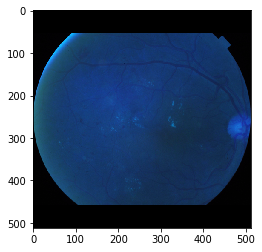

In [12]:
image = cv2.imread(f'aptos2019-blindness-detection/train512/000c1434d8d7.png')
plt.imshow(image)

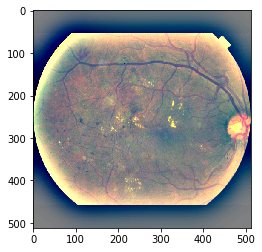

In [9]:
from matplotlib import pyplot as plt

image = cv2.imread(f'aptos2019-blindness-detection/train512/000c1434d8d7.png')
image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
image = cv2.addWeighted(image,4, cv2.GaussianBlur( image , (0,0) , 30) ,-4 ,128)
plt.imshow(image)

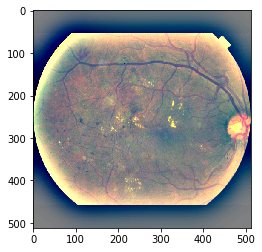

In [15]:
image = cv2.imread(f'aptos2019-blindness-detection/train512/000c1434d8d7.png')
image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
image = cv2.addWeighted(image,4, cv2.GaussianBlur( image , (0,0) , 30) ,-4 ,128)
plt.imshow(image)

In [10]:

IMG_SIZE = 224
num_channels = 3 
xtrain = np.zeros((3662, IMG_SIZE, IMG_SIZE, num_channels), dtype=np.uint8)

for i, image_id in enumerate(tqdm(train_df['id_code'])):
    image = cv2.imread(f'aptos2019-blindness-detection/train224/{image_id}.png')
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    image = cv2.addWeighted(image,4, cv2.GaussianBlur( image , (0,0) , 30) ,-4 ,128)
    xtrain[i,:,:,:] = image

100%|██████████| 3662/3662 [10:35<00:00,  5.76it/s]


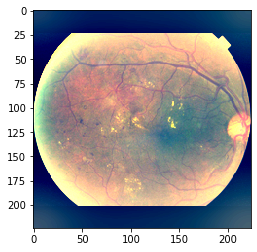

In [17]:
plt.imshow(xtrain[0])

In [18]:
from numpy import asarray
from numpy import save

data = asarray(xtrain)
save('aptos2019-blindness-detection/xtrain2224.npy', data)